# Assignmnent 1: Expressive Timing in Performance
In this assignment we explore the distortion of the metrical grid in human performance. Your task is to find a interesting mapping from symbolic time to real time.

Dataset: https://github.com/fosfrancesco/asap-dataset.

- For each piece, the dataset contains two versions of MIDI files:
  - unperformed MIDI corresponds to strict timing as shown in the score.
  - performed MIDI corresponds to MIDI recording from human musicians performing the piece. In these files you will find the timing of the notes does not corresponds strictly to the symbolic metrical grid (i.e. the metrical grid is distorted).
- The dataset contains pieces from different styles, you can decide which subcollection to use.
- The dataset does not contain information about loudness/dynamics in the MIDI files (in a MIDI file this is called the "velocity" attribute). For this assignment, any attempts to model velocity will be considered a plus and you can do it freely according to your musical intuition.


In [1]:
# Import libraries
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change the path if necessary:
root_dir = '/content/drive/Shareddrives/dh401_digital_musicology/Mozart_Piano_Sonatas/8-1/'
os.chdir(root_dir)

## Task A.1. Analysis of timing in the performances of chosen corpus

In [4]:
def preprocessing(path):
  annotations = pd.read_csv(path, sep='\t', header=None, names=['time', 'time1', 'info'])
  annotations = annotations.drop(columns = ['time1'])
  annotations[['info', 'metrics', 'number']] = annotations['info'].str.split(',', expand=True)
  return annotations

In [9]:
performed_annotations = preprocessing(root_dir+'Jia01_annotations.txt')
unperformed_annotations = preprocessing(root_dir+'midi_score_annotations.txt')

In [10]:
def separate_time_sigs(df):

  df.replace('', None, inplace=True)
  indices = df.index[df['metrics'].notnull()].tolist()

  if indices[-1] != df.index[-1]:
      indices.append(df.index[-1])

  separated_dfs = []

  start_idx = 0
  for idx in indices:
      separated_df = df[start_idx:idx + 1]
      separated_df = separated_df.reset_index().drop(columns = ['index', 'number'])
      separated_dfs.append(separated_df)
      start_idx = idx

  return separated_dfs

In [11]:
separated_performed = separate_time_sigs(performed_annotations)
separated_unperformed = separate_time_sigs(unperformed_annotations)

In [12]:
def number_of_beats_in_compound_time(time_signature):

  # Split the time signature into its components
  numerator, denominator = map(int, time_signature.split('/'))

  # Check if the time signature is compound
  if (denominator / 4)  == 2:
      return numerator // 3
  else:
      return numerator

In [13]:
def add_beats(df_list):
  for df in df_list:
    if (df['metrics'].iloc[0] != None):
        beats = number_of_beats_in_compound_time(df['metrics'].iloc[0])
        df['beat_number'] = df.index % beats+1
    else:
      df_list.remove(df)

    df.loc[df['info'] == 'bR', 'beat_number'] = 'bR'

  return df_list


In [14]:
separated_unperformed = add_beats(separated_unperformed)
separated_performed = add_beats(separated_performed)

In [15]:
def add_durations(df_list):
  for df in df_list:
    for i, row in df.iterrows():
      if i+1 != len(df):
        df.loc[i, 'duration'] = float(float(df['time'].loc[i+1]) - float(row['time']))
    df.drop(df.tail(1).index,inplace=True)
  if df_list[0].empty:
    df_list = df_list[1:]

  return df_list

In [16]:
separated_performed = add_durations(separated_performed)
separated_unperformed = add_durations(separated_unperformed)

In [17]:
# Add performed relative durations of beats

for i in range(len(separated_performed)):
  df_per = separated_performed[i]
  df_unp = separated_unperformed[i]
  for j, row in df_per.iterrows():
    df_per.loc[j, 'relative duration'] = float(row['duration']) / float(df_unp.loc[j, 'duration'])


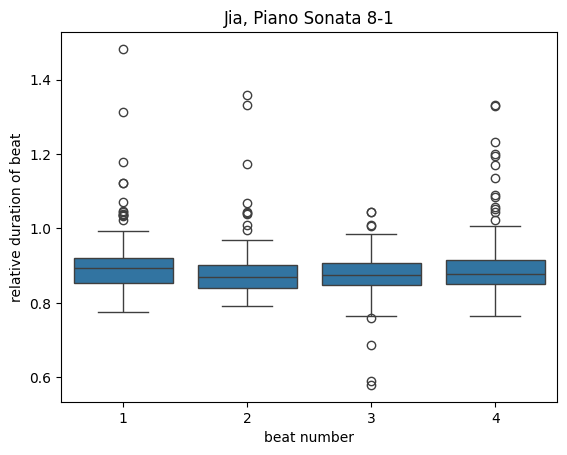

In [20]:
# Plot the box plots for each beat in bar

if len(separated_performed) > 1:
  fig, axes = plt.subplots(1, len(separated_performed), figsize=(8*len(separated_performed), 4))
  for ax, df in zip(axes, separated_performed):
    sns.boxplot(data = df, x='beat_number', y='relative duration', ax=ax)

sns.boxplot(data = separated_performed[0], x='beat_number', y='relative duration')
plt.xlabel('beat number')
plt.ylabel('relative duration of beat')
plt.title('Jia, Piano Sonata 8-1')
plt.show()

In [19]:
# separated_performed[0].to_csv('dataframes romane/8-1 Jia', sep=',', index=False, encoding='utf-8') # uncomment if you want to save the dataframe